# Tarea 1 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, aplicaremos los conocimientos aprendidos en el curso para evaluar el funcionamiento de distintos algoritmos de recomendación sobre el dataset de películas MovieLens. Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

# Setup inicial

## Instalación Visual C++ Build Tools (Windows)

Para poder instalar la librería Surprise que será utilzada en la tarea en un sistema operativo Windows, se necesitan tener instaladas las Visual C++ Build Tools.

Estas pueden ser descargadas a través de [este link](https://visualstudio.microsoft.com/es/visual-cpp-build-tools/). Una vez que hayan descargado el ejecutable, asegúrense de marcar la opción **Desarrollo para el escritorio con C++** y reiniciar su equipo una vez finalice la descarga

## Descarga del dataset

Vamos a descargar el dataset MovieLens-100k proporcionado de manera abierta por [GroupLens de la Universidad de Minnesota](https://grouplens.org/). Este dataset consiste en $100.000$ *ratings* de $943$ usuarios de la plataforma [MovieLens](https://movielens.org/home) en $1.682$ películas.

Podemos descargar el dataset directamente con el comando wget.

In [1]:
!pip install wget
!pip install zipfile36
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2045fc96ba4e3a8b1a6cc8475f4aca87c4a2a807f17e3b2cee52c20f410fbdd6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

Saved under ml-100k.zip


In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

El archivo *u.data* contiene los $100.000$ ratings. Además, el dataset contiene divisiones de entrenamiento y testeo en los archivos *.base* y *.test*. Los archivos desde u1 hasta u5 corresponden a *splits* del 80% / 20% del dataset original.

Para efectos de esta tarea, solo trabajaremos con los archivos *u1.base* y *u1.test*, por lo que guardaremos su ruta.

In [3]:
train_dir = "ml-100k/u1.base"
test_dir = "ml-100k/u1.test"

# Dataset

Las siguientes celdas les permitirá descargar el dataset MovieLens 100k de manera local.

Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos la información contenida en el set de entrenamiento. Para esto, usaremos la librería Pandas, que nos permite manejar bases de datos.

In [4]:

import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


### Pregunta 1 (6 puntos):

Podemos ver que los archivos *u.base* contienen información del usuario, el item, el rating y el timestamp. ¿A qué tipo de información corresponde esto? (Por ejemplo, feedback implícito/explícito, contextual, de contenido, etc).

En base a esto, ¿Qué método de recomendación visto en clase sugiere usar para recomendar películas nuevas a los usuarios?

#### Respuesta:

En este caso, estamos ante un feedback explícito, dado que el ránking es conocido en los datos y además es entregado por los usuarios para cada ítem rankeado por este. Por otra parte, tenemos un timestamp, el cual podría ser utilizado como dato contextual al segmentar según el período en que se realizó la evaluación del ítem.

Dado lo anterior, y debido a que sabemos que no todos los usuarios rankearon todos los ítems, tenemos dispersión en los datos. En tal caso podemos considerar utilizar el método FunkSVD como una buena alternativa.

### Pregunta 2 (6 puntos):

Observemos ahora cómo se distribuyen la cantidad de interacciones por usuario y la cantidad de interacciones por ítem.

[Text(0.5, 1.0, 'Número de interacciones por usuario'),
 Text(0.5, 0, 'Cantidad de items'),
 Text(0, 0.5, 'Cantidad de usuarios')]

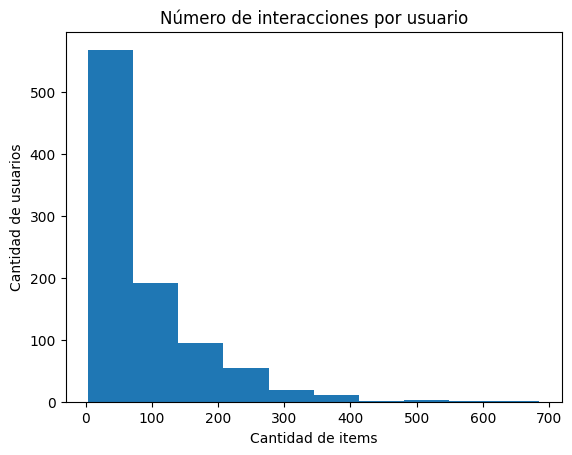

In [5]:
import matplotlib.pyplot as plt

distrib = train_file.groupby(['userid']).count().sort_values(by=['itemid'], ascending=False)
x = distrib['itemid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por usuario', xlabel='Cantidad de items', ylabel='Cantidad de usuarios')

[Text(0.5, 1.0, 'Número de interacciones por item'),
 Text(0.5, 0, 'Cantidad de interacciones'),
 Text(0, 0.5, 'Numero de items')]

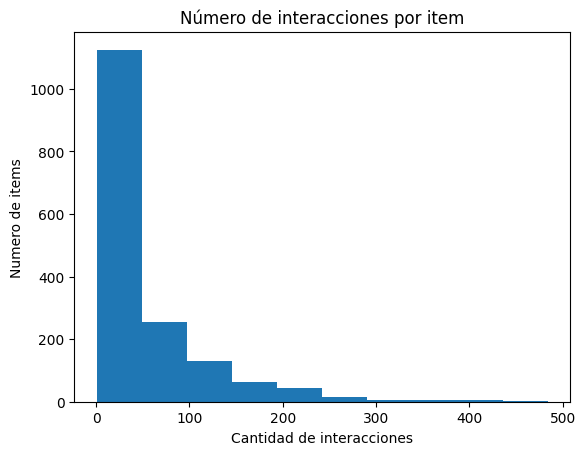

In [6]:
distrib_item = train_file.groupby(['itemid']).count().sort_values(by=['userid'], ascending=False)
x = distrib_item['userid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por item', xlabel='Cantidad de interacciones', ylabel='Numero de items')

Representando la data como histogramas, podemos observar la distribución de las interacciones. Por ejemplo, la primera barra del primer histograma nos indica cuántos usuarios del dataset tienen entre $0$ y $50$ interacciones.

Observe estos datos y comente acerca de la forma de los gráficos y qué significa esta forma en el contexto, tanto para los usuarios como para los ítems. ¿Qué problema podría significar esto para un sistema recomendador?

#### Respuesta:

En este caso podemos ver que las distribuciones de interacciones por usuario o ítem no son similares a una distribución normal, sino que están cargadas hacia la izquierda. De acuerdo con lo anterior, podemos ver primero el caso de interacciones desde el punto de vista de los usuarios.

En este primer caso, podemos ver que una notable mayoría de usuarios ha rankeado a lo más 200 ítems, de un total de 700. Esto nos hace pensar que ya tendríamos muchos espacios en la matriz usuario - ítem de ránkings no conocidos, lo cual puede ser importante al momento de considerar algoritmos de filtrado colaborativo como uKNN, dado que existe el problema del cold start. Similarmente, no se podría ocupar la factorización SVD a secas por tener matrices dispersas.

En el caso de los ítems es similar. La mayoría de los ítems han sido rankeados por a lo más 100 personas, por lo que el cold start estaría presente en iKNN y en SVD, experimentando nuevamente matrices dispersas.

Para lo anterior, cobraría más relevancia utilizar FunkSVD.

## Como ver la información de una o más películas

Ahora vamos a aprender algunos métodos de la biblioteca de Pandas que nos permiten ver los detalles de algunas interacciones

In [7]:
# Ver la o las filas específicas del usuario con id = 310
train_file[train_file['userid'] == 310]

,userid,itemid,rating,timestamp
17949,310,50,5,879436177
17950,310,294,1,879436712
17951,310,1142,5,879436467
17952,310,1386,1,879436177


Podemos ver que el usuario con ID $310$ tiene $4$ interacciones en el set de entrenamiento

El archivo *u.item* contiene información adicional de cada película, tal como *título*, *fecha de lanzamiento*, *género*, etc.

La columna *movieid* corresponde a la columna *itemid* de nuestra tabla *train_file*, lo que nos permite conectar la información de esta tabla con nuestro dataset original.

In [8]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [9]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [10]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.


Para ver la información de más de una película, se realizan los siguientes pasos
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

Por ejemplo, veamos cuáles fueron las $4$ películas que vio el usuario $310$

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [50,294,1142,1386]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1142,When We Were Kings (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?When%20We%20W...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1386,Tetsuo II: Body Hammer (1992),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Tetsuo+II%3A+...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Para éste código:
1. `pelis = [50,294,1142,1386]` indica que queremos imprimir los detalles de las películas con estos índices. (En este caso, el índice corresponde al movieid)
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [12]:
# Paso 3, acceder solo a columnas específicas
info_file.loc[pelis]['title']

movieid
50                   Star Wars (1977)
294                  Liar Liar (1997)
1142        When We Were Kings (1996)
1386    Tetsuo II: Body Hammer (1992)
Name: title, dtype: object

## Preparar entorno
Para generar los modelos recomendadores, utilizaremos la librería [***Surprise***](https://github.com/NicolasHug/Surprise) desarrollada por Nicolas Hug.

In [13]:
!pip install scikit-surprise==1.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163001 sha256=0c6a149e1fb04a61f497feeaeaa7f848d98d8e35d1ca350682d9b9a026eaafa0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en esta tarea

In [14]:
import surprise
print(surprise.__version__)
from surprise.model_selection import PredefinedKFold
import numpy as np
from collections import defaultdict

1.1.3


## UserKNN

Probar método de recomendación basado en ***UserKNN***

Antes de generar el recomendador, hay que convertir los datos a un formato que sea soportado por la librería Surprise. Para esto, utilizamos la función Reader que convierte una base de datos de un archivo al formato deseado.

In [15]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

Se puede ver que al objeto Reader le estamos entregando:
* ***line_format:*** El orden de las columnas que representan cada elemento del dataset (debe tener el formato que se muestra y estar separadas por espacios).
* ***sep:*** El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***rating_scale:*** La escala usada en los ratings (en este caso los ratings van del $1$ al $5$)

Luego, usamos el módulo Dataset de Surprise para usar el objeto Reader para leer los datos de un archivo. En este caso, ya que tenemos el set de entrenamiento y testeo en archivos separados, usamos la función ***load_from_folds*** que recibe una lista de tuplas con los nombres de los archivos de entrenamiento y testeo. Existen también funciones que permiten leer todos los items de un solo archivo, cargar datasets predefinidos o importarlos desde un dataframe de Pandas. Pueden leer estas aplicaciones en la [_documentación_](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin).

Finalmente, la función ***pkf.split*** entrega un generador que itera sobre los archivos de entrenamiento y testeo que definimos en la lista que le entregamos a ***load_from_folds***. En este caso, como solo contamos con un archivo de entrenamiento y uno de testeo, invocamos la función ***next*** para definir los datasets como el primer output del generador.

Finalmente declaramos el objeto recomendador que vamos a usar:

In [16]:
# Declarar el objeto recomendador UserKnn
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [17]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [18]:
myUserKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.4420114287810444, details={'actual_k': 6, 'was_impossible': False})

El valor de `est` es la estimación que el modelo hace para el usuario y objeto correspondiente. En este caso, el modelo predice que el usuario $457$ le daría una calificación de $2.44$ al item $37$.

El valor de `r_ui` es el valor real que el usuario le dio al objeto. Si en el set de entrenamiento, existiera un registro de la calificación que le dio el usuario $457$ al item $37$, esta se vería reflejada en ese valor, el cual no necesariamente será el mismo que el valor predicho por el agente. En eeste caso, como el usuario $457$ no ha visto el item $37$, este valor es `None`

## Generar una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

Para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [19]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [20]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [21]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1347', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5), ('1189', 4.999999999999999)]


Cada item de la lista `top_n` representa una tupla de el ID del ítem recomendado y su calificación predicha.

Usemos ahora la función `.loc` para analizar las películas recomendadas.

In [22]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1347,"Ballad of Narayama, The (Narayama Bushiko) (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Narayama%20Bu...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1656,Little City (1998),20-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Little+City+(...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Usuarios), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

La biblioteca Surprise tiene un modulo `accuracy` que permite calcular distintas métricas de error, entre ellas el RMSE y el MAE.

Para evaluar un modelo entrenado, utilizamos la función `.test()` sobre el testset, lo que nos permite calcular la diferencia entre los valores predichos y los valores reales para los elementos del set de testeo.

In [23]:
from surprise import accuracy

k_values = [5, 10, 15] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0347
MAE:  0.8197
RMSE: [1.0880066691561228, 1.0470099288376837, 1.034653750064812]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8197339697540738]


### Evaluar en base a error de prediccion (RMSE y MAE)

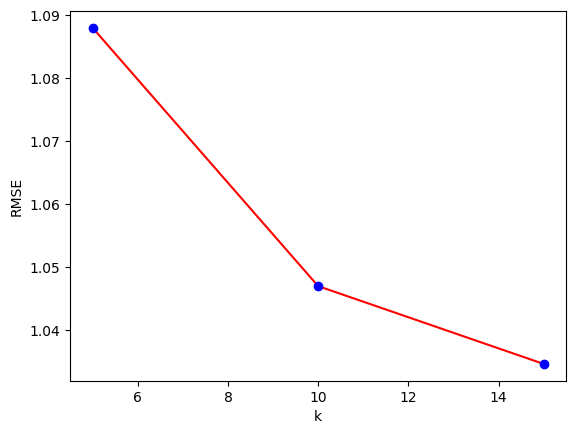

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

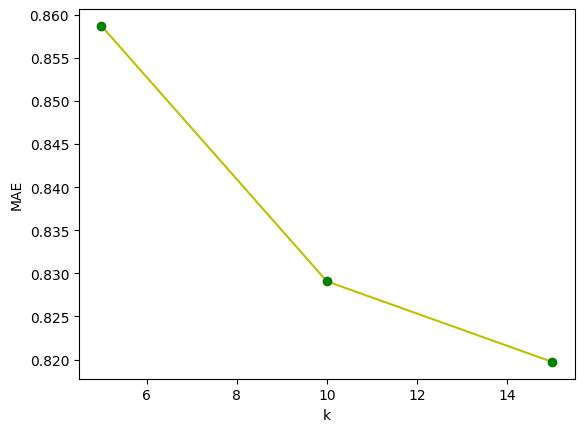

In [25]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

Entrenamos un nuevo agente con valores de `k = 5, 10, 15` y podemos observar que tanto el valor del RMSE y del MAE disminuyeron con un mayor valor de `k`.

### Pregunta 3 (12 puntos):

Continúe el estudio de los hiperparámetros para los valores de `k = 5, 10, 30, 50, 70, 100 y 150`. Grafique sus resultados y conteste:

* Explique, en sus propias palabras, qué se mide con las métricas de RMSE y MAE.
* Qué valor de `k` entrega los mejores resultados.
* Comente acerca de la forma del gráfico y explique por qué se obtiene un gráfico de esta forma.

#### Respuesta:

In [26]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values_uknn = [] # para almacenar resultados de MAE
rmse_values_uknn = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions_uknn = myUserKnn.test(testset)
  rmse_values_uknn.append(accuracy.rmse(predictions_uknn))
  mae_values_uknn.append(accuracy.mae(predictions_uknn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0248
MAE:  0.8139
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8125
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0227
MAE:  0.8136
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0249
MAE:  0.8164


Calculamos los gráficos para MAE y RMSE

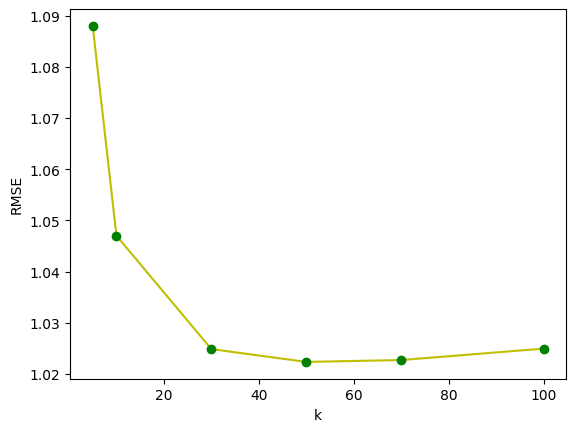

In [27]:
plt.plot(k_values, rmse_values_uknn, 'y-')
plt.plot(k_values, rmse_values_uknn, 'go')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

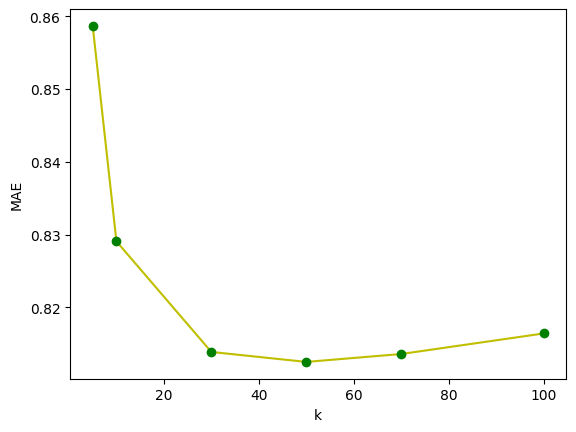

In [28]:
plt.plot(k_values, mae_values_uknn, 'y-')
plt.plot(k_values, mae_values_uknn, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

# Respuesta

1.

`RMSE`: En el RMSE medimos la raíz del error cuadrado medio. En palabras simples, calculamos la diferencia cuadrática del valor real del ránking versus el valor predicho para cada dato. Luego calculamos el promedio de dichos errores, con lo que sabemos la diferencia cuadrática promedio entre un dato predicho vs un dato real, en este caso el ránking. Se eleva al cuadrado para evitar que la diferencia sea negativa y así medir el error en términos absolutos. A todo lo anterior se le aplica la raíz cuadrada, teniendo números más bajos y manejables de error, sin perder monotonía (la raíz cuadrada siempre dará un número menor al original para cualquier número real mayor o igual a 0).

`MAE`: El `MAE` es similar al RMSE en términos de medir, en promedio, la distancia entre un dato predicho vs un dato real. La diferencia radica en que en el `MAE`, en vez de calcular la diferencia cuadrática (el cual siempre dará mayor a 0), se calcula la diferencia absoluta entre el valor real vs el valor predicho, pero en valor absoluto, a modo de evitar la cancelación de la suma de errores por tener eventualmente valores positivos y negativos. En este caso, dado que el error no se eleva al cuadrado, no se torna necesario aplicar la raíz cuadrado, dado que no es un número que tiende a crecer en gran medida.

In [29]:
mae_values_uknn[3]

0.8125053209390201

In [30]:
rmse_values_uknn[3]

1.0223262772265247

2.

Para ambos casos, se logra ver que con `k = 50` se logra llegar a un valor óptimo, dado que es el valor de `k` que minimiza el `RMSE` y `MAE`. También, tenemos que `RMSE=1.0223` y `MAE=0.8125`.

3.

Se ve en ambos gráficos que la curva tiende a tener un mínimo global y una concavidad negativa, lo cual nos indica que existe un cierto valor dentro del 1 a la cantidad de datos menos 1 en el cual se minimiza el error. Lo anterior tiene sentido con la implementación del algoritmo KNN. Si tenemos un `k` demasiado bajo, utilizaremos muy pocos vecinos cercanos, lo cual tiende a generar una pérdida en la capacidad de generalización del algoritmo, ya que se tiende a utilizar la información solo local y no más general, estando sujeto a la distribución de entrenamiento de los datos generando overfitting. En el caso contrario, si el `k` es muy alto, estamos sub entrenando el algoritmo, ya que estamos considerando gran parte de los vecinos, teniendo un ránking promedio muy poco ajustado a casos específicos. El caso más extremo es asignar el valor promedio de todos los vecinos, para cada dato, lo cual siempre tenderá a arrojar un valor similar para todos los datos.

### Pregunta 4 (12 puntos):

Repita el experimento anterior, pero utilizando los algoritmos de IKNN y [FunkSVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) de la biblioteca Surprise. Recuerde evaluar el rendimiento de sus modelos para las métricas de RMSE y MAE

* Para el caso de IKnn vuelva a realizar un análisis con los valores de `k = 5, 10, 30, 50, 70, 100` e identifique el valor que entrega el mejor resultado.

#### Respuesta:

## iKNN

Aplicamos `iKNN`y graficamos

In [31]:
k_values = [5, 10, 30, 50, 70, 100]
mae_values_iknn = []
rmse_values_iknn = []

for k in k_values:
  myItemKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False})
  myItemKnn.fit(trainset)
  predictions_iknn = myItemKnn.test(testset)
  rmse_values_iknn.append(accuracy.rmse(predictions_iknn))
  mae_values_iknn.append(accuracy.mae(predictions_iknn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2026
MAE:  0.9458
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1183
MAE:  0.8810
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0535
MAE:  0.8310
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0474
MAE:  0.8257
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0489
MAE:  0.8294
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0528
MAE:  0.8364


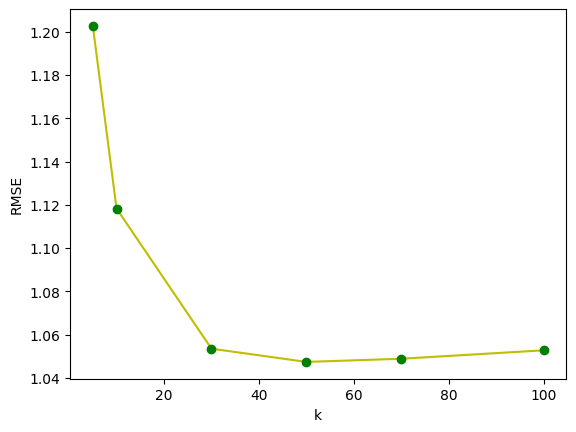

In [32]:
plt.plot(k_values, rmse_values_iknn, 'y-')
plt.plot(k_values, rmse_values_iknn, 'go')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

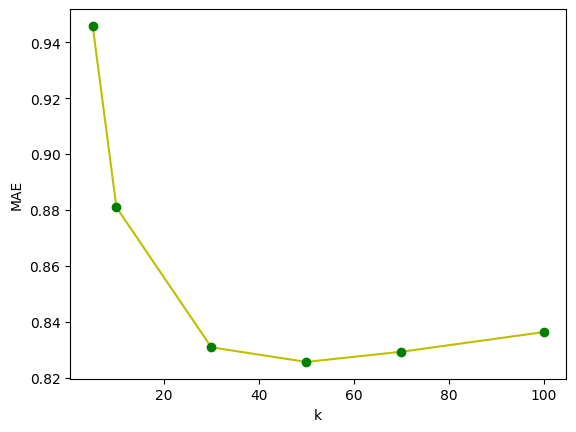

In [33]:
plt.plot(k_values, mae_values_iknn, 'y-')
plt.plot(k_values, mae_values_iknn, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

In [34]:
mae_values_iknn[3]

0.8257379441539587

In [35]:
rmse_values_iknn[3]

1.0474114308369047

Podemos ver que nuevamente el valor de `k=50` es el óptimo para `iKNN`, muy similar a `uKNN`, dando como `RMSE=1.047` y `MAE=0.826`.

## FunkSVD

Importamos los objetos necesarios

In [36]:
from surprise.prediction_algorithms import SVD

In [37]:
# Utilizamos el trainset y lo entrenamos
funkSVD = SVD()
funkSVD.fit(trainset)


In [38]:
# Calculamos las predicciones y evaluamos
predictions_funksvd = funkSVD.test(testset)

rmse_funksvd = accuracy.rmse(predictions_funksvd)
mae_funksvd = accuracy.mae(predictions_funksvd)

RMSE: 0.9532
MAE:  0.7501


Tenemos que el modelo `FunkSVD` tiene un `RMSE=0.9507` y `MAE=0.7498`, siendo valores menores al modelo de KNN basado en ítems. De esta forma, el modelo `FunkSVD` termina arrojando mejores predicciones de ránkings.

### Pregunta 5 (12 puntos):

Genere una tabla que compare los resultados de los métodos de UKnn, IKnn y FunkSVD tanto para RMSE como para MAE. En el caso de IKnn y UKnn, solo utilice el modelo con el valor de `k` que haya entregado los mejores resultados. Identifique qué método logró el mejor resultado para ambas métricas.

Comente acerca de estos resultados. Explique por qué cree que se obtuvieron estos resultados utilizando la materia aprendida en el curso respecto al funcionamiento de cada método.

#### Respuesta:

In [39]:
# Generamos los datos de la tabla
metrics_data = {
    'model': ['uKNN', 'iKNN', 'FunkSVD'],
    'RMSE': [rmse_values_uknn[3], rmse_values_iknn[3], rmse_funksvd],
    'MAE': [mae_values_uknn[3], mae_values_iknn[3], mae_funksvd]
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df.head()

,model,RMSE,MAE
0,uKNN,1.022326,0.812505
1,iKNN,1.047411,0.825738
2,FunkSVD,0.953210,0.750060


Podemos ver que claramente `FunkSVD` logró las mejores métricas para `RMSE` y `MAE`, siendo estas los valores más bajos. Importante notar que estamos midiendo error promedio y por lo tanto queremos minimizarlo.

Es esperable que `FunkSVD` tenga un mejor performance que `uKNN` o `iKNN`. En el dataset que tenemos, inicialmente vimos que tenemos muchos ítems con pocas cantidad de valoraciones, en comparación al total, así como también muy poca cantidad de eventos de valoración en la mayoría de los usuarios. Lo anterior genera cold start de los algoritmos del tipo KNN, dado que existirán muchos ítems o usuarios que no tendrán valoraciones o muy pocas y por lo tanto el algoritmo se tornará varias iteraciones iniciales para ir avanzando en generar mejores predicciones, o bien, requerirán de un `k` más alto.

En contraparte, el `FunkSVD` maneja este problema, el cual es común en sistemas reales, dado que al tener una matriz altamente dispersa, en realidad partimos utilizando una matriz más reducida pero que no sea dispersa, siendo la minoría de las relaciones usuario - ítem. Luego estimamos el ranking en base a pocos factores. Luego, con los errores que obtenemos vamos minimizandolos en base a la técnica de descenso de gradiente.

### Pregunta 6 (12 puntos):

Escoja un usuario del set de datos e imprima los títulos de las películas que ha visto (según el set de entrenamiento) y su calificación. Luego, imprima una lista de 5 recomendaciones entregadas para este usuario por cada uno de los $3$ modelos entrenados y compare estas listas. Comparando los gustos en la historia del usuario y las recomendaciones entregadas por los modelos, le hacen sentido estas recomendaciones. (Su respuesta no necesariamente debe coincidir con las conclusiones finales de la sección experimental).

Evite usar a los usuarios 457 y 310 que ya fueron estudiados en la tarea. Recuerde imprimir al menos los títulos de cada película, tanto en la historia del usuario como en las recomendaciones para poder identificarlas correctamente.

#### Respuesta:

Se escogerá el usuario `200`

In [40]:
user_id = 200

Obtenemos los nombres de peliculas que le ha aplicado su rating

In [41]:
filtered_df = train_file[train_file['userid'] == user_id]
filtered_df

,userid,itemid,rating,timestamp
10601,200,1,5,876042340
10602,200,9,4,884126833
10603,200,22,4,884128372
10604,200,28,5,884128458
10605,200,43,3,884129814
...,...,...,...,...
10708,200,1073,3,884129542
10709,200,1091,4,884129814
10710,200,1217,4,884130014
10711,200,1219,3,884130289


Imprimimos el historial de películas calificadas junto a su rating

In [42]:
movie_ratings = filtered_df['rating'].tolist()
movies_id = filtered_df['itemid'].tolist()
movie_names = info_file.loc[movies_id]['title'].tolist()

movie_info = list(zip(movie_names, movie_ratings))
movie_info

[('Toy Story (1995)', 5),
 ('Dead Man Walking (1995)', 4),
 ('Braveheart (1995)', 4),
 ('Apollo 13 (1995)', 5),
 ('Disclosure (1994)', 3),
 ('Hoop Dreams (1994)', 2),
 ('Outbreak (1995)', 4),
 ('Quiz Show (1994)', 4),
 ('Stargate (1994)', 5),
 ('Santa Clause, The (1994)', 4),
 ('Crow, The (1994)', 5),
 ('Forrest Gump (1994)', 5),
 ('Lion King, The (1994)', 4),
 ('Fugitive, The (1993)', 5),
 ('Blade Runner (1982)', 5),
 ('Nightmare Before Christmas, The (1993)', 4),
 ('Home Alone (1990)', 4),
 ('Aladdin (1992)', 5),
 ('Silence of the Lambs, The (1991)', 5),
 ('Snow White and the Seven Dwarfs (1937)', 5),
 ('Moll Flanders (1996)', 3),
 ('Rock, The (1996)', 5),
 ('Twister (1996)', 4),
 ('Wizard of Oz, The (1939)', 5),
 ('Love Bug, The (1969)', 3),
 ('20,000 Leagues Under the Sea (1954)', 4),
 ('Top Gun (1986)', 4),
 ('Wrong Trousers, The (1993)', 5),
 ('Empire Strikes Back, The (1980)', 5),
 ('Aliens (1986)', 5),
 ('Good, The Bad and The Ugly, The (1966)', 4),
 ('Clockwork Orange, A (1971

Obtenemos las recomendaciones por cada modelo. Los instanciamos y entrenamos nuevamente por las dudas

In [43]:
k_knn = 50

uKNN = surprise.KNNBasic(k=k_knn, sim_options={'name': 'cosine', 'user_based': True})
iKNN = surprise.KNNBasic(k=k_knn, sim_options={'name': 'cosine', 'user_based': False})
funkSVD = SVD()

In [44]:
uKNN.fit(trainset)
iKNN.fit(trainset)
funkSVD.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


Obtenemos las predicciones del usuarios

In [46]:
def get_predictions(clf, user_id, movies_id, funk=False):
  if not funk:
    predictions = [clf.predict(str(user_id), str(movie_id)) for movie_id in movies_id]
  else:
    predictions = [clf.predict(user_id, str(movie_id)) for movie_id in movies_id]
  return predictions

movies_id = train_file['itemid'].unique().tolist()
predictions_uknn = get_predictions(uKNN, user_id, movies_id)
predictions_iknn = get_predictions(iKNN, user_id, movies_id)
predictions_funksvd = get_predictions(funkSVD, user_id, movies_id, funk=True)

In [47]:
top_5_uknn = get_top_n(predictions_uknn, 5)[str(user_id)]
top_5_iknn = get_top_n(predictions_iknn, 5)[str(user_id)]
top_5_funksvd = get_top_n(predictions_funksvd, 5)[user_id]

In [48]:
top_5_funksvd

[('408', 4.61836653721861),
 ('169', 4.614695748588152),
 ('318', 4.562023348522711),
 ('64', 4.537298313221161),
 ('483', 4.506235263673112)]

In [49]:
top_5_uknn

[('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1189', 5)]

In [50]:
top_5_iknn

[('1342', 5),
 ('1614', 4.636363636363637),
 ('1500', 4.555555555555555),
 ('1212', 4.497482247074901),
 ('1595', 4.483870967741935)]

Ahora compararemos con la historia del usuario

In [55]:
info_uknn = info_file.loc[[int(rat[0]) for rat in top_5_uknn]]
info_iknn = info_file.loc[[int(rat[0]) for rat in top_5_iknn]]
info_funk = info_file.loc[[int(rat[0]) for rat in top_5_funksvd]]

In [56]:
info_uknn

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1189,Prefontaine (1997),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Prefontaine%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [57]:
info_iknn

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1342,"Convent, The (Convento, O) (1995)",14-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Convento,%20O...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1614,"Reluctant Debutante, The (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Reluctant%20D...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1212,Flesh and Bone (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Flesh%20and%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
1595,Shopping (1994),09-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Shopping%20(1...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
info_funk

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [74]:
best_5_movies = filtered_df.sort_values(by='rating', ascending=False)['itemid'].tolist()[:5]
best_5_movies = [str(i) for i in best_5_movies]
best_5_movies_df = info_file.loc[[int(rat) for rat in best_5_movies]]
best_5_movies_df

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
385,True Lies (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?True%20Lies%2...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
176,Aliens (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Aliens%20(1986),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
195,"Terminator, The (1984)",01-Jan-1984,NaN,"http://us.imdb.com/M/title-exact?Terminator,%2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
202,Groundhog Day (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Groundhog%20D...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Vemos que en ninguno de los casos se logra ver realmente una conexión entre las películas que el usuario más le gustó, versus aquellas que fueron recomendadas, en términos de su contenido.

Sin embargo, podemos ver que en el caso de `FunkSVD` hay una prevalencia por ver películas de drama y o de la década de los 90 o clásicos de años menores al 1950. Esto puede tener que ver con las preferencias del usuario, en el que las 5 películas que mejor rating asignó son todas del 90 y tienen una componente de drama. Por otra parte, vemos que tanto en `iKNN` como `uKNN` tiende a existir una tendencia similar a `FunkSVD` en términos de la época de las películas. Se ve que 4 de las 5 películas ronda entre la década de 80 o 90s, pero la otra película es del año 1950 hacia abajo. Eso puede ser un patrón importante a considerar, en que el usuario le podrían gustar los clásicos o bien películas no tan antiguas de drama. También se puede interpretar que el factor de fecha de lanzamiento de la película podría tomar más relevancia en la recomendación de mejores películas para el usuario.